# Snake

In [1]:
from environments import *
import numpy as np
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import os
import json
from models import *
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
LOAD_FROM_MEMORY = True
USE_CURRICULUM = False
DECORRELATED_BATCH = None

## Environment definition

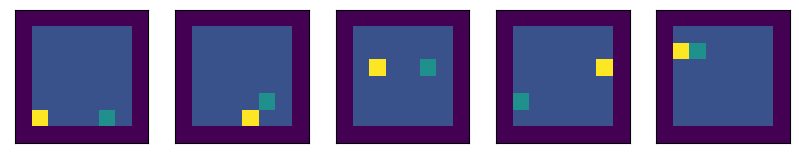

In [3]:
%matplotlib inline
def get_env(n=1000):
    return OriginalSnakeEnvironment(n, 8)
env_ = get_env()
GAMMA = .9
ITERATIONS = 1000
EPSILON = 0.1
LAMBDA_VALUE = 0.1
LAMBDA_AGENT = 0.1
#  ALPHA = 0.1

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Demo

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
demo_env = get_env(1000)
def animate(_):
    original_probs = tf.convert_to_tensor([[.25]*4]*demo_env.n_boards)
    mask = get_probabilities_mask(demo_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]
    actions = tf.random.categorical(tf.math.log(probs),1)
    demo_env.move(actions)
    for board, image in zip(demo_env.boards, images):
        image.set_data(board)
    return images

In [7]:
fig, axs = plt.subplots(1,4, figsize=(10,3))
images = []
for b, ax in zip(demo_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>

## Model

In [167]:
MODELS_PREFIX = f"py/models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)

In [168]:
agent, value, avg_rewards = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

## Training

In [169]:
avg_td_error = []

In [170]:
optimizer_value = K.optimizers.Adam(1e-4)
optimizer_agent = K.optimizers.Adam(1e-4)

In [171]:
def norm(grad):
    return tf.reduce_sum([tf.norm(np.reshape(a, (-1)), ord=1) for a in grad])

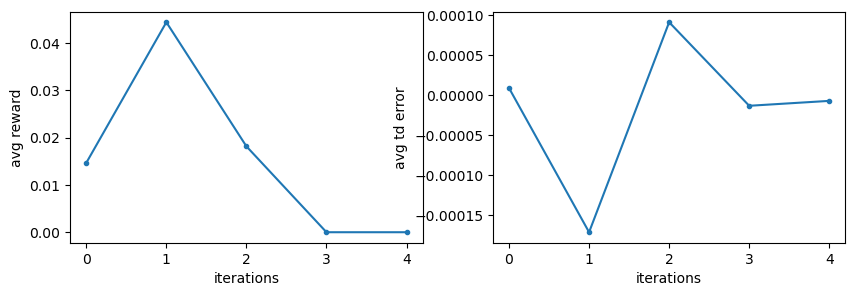

100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s]


In [172]:
%matplotlib inline
eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]
next_reset = 2
for iteration in trange(ITERATIONS):
    if next_reset == iteration and USE_CURRICULUM:
        clear_output(wait=True)
        print(f"resetting at iter {iteration}")
        next_reset += int(next_reset ** (3/4))
        env_ = get_env(env_.n_boards)
        eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
        eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]

    state = env_.to_state()
    with tf.GradientTape(persistent=True) as tape:

        original_probs = agent(state)
        mask_with = 0.
        mask = get_probabilities_mask(env_.boards, original_probs.shape, mask_with=mask_with)
        probs = tf.linalg.normalize((original_probs + EPSILON) * mask, ord=1, axis=-1)[0]

        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())

        if DECORRELATED_BATCH is not None:
            to_consider = np.floor(np.random.random_sample(env_.n_boards) * env_.n_boards).astype(int)
            state = state[to_consider]
            original_probs = tf.gather(original_probs, to_consider, axis=0)
            mask = mask[to_consider]
            probs = tf.gather(probs, to_consider, axis=0)
            actions = tf.gather(actions, to_consider, axis=0)
            rewards = tf.gather(rewards, to_consider, axis=0)
            new_state = tf.gather(new_state, to_consider, axis=0)

        value_state = value(state)
        new_value_state = value(new_state)
        td_error = tf.stop_gradient((rewards + GAMMA * new_value_state) - value_state) * -1

        not_available_actions_indexes = tf.convert_to_tensor(
            np.argwhere(np.logical_and(mask == mask_with, original_probs > .2)),
            dtype=tf.int32
        )
        not_available_td_error = tf.abs(tf.gather_nd(td_error, not_available_actions_indexes[:,0,None]))
        loss_not_available_single = tf.gather_nd(original_probs, not_available_actions_indexes)[...,None] * not_available_td_error
        loss_not_available = tf.reduce_mean(tf.math.log(loss_not_available_single))

        actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)
        loss_agent = tf.math.log(tf.gather_nd(original_probs, actions_indexes))[..., None] * tf.stop_gradient(td_error)
        loss_value = tf.stop_gradient(td_error) * value_state

        loss_agent = tf.reduce_mean(loss_agent)
        loss_value = tf.reduce_mean(loss_value)

    avg_td_error.append(tf.reduce_mean(td_error))
    avg_rewards.append(np.mean(rewards == env_.FRUIT_REWARD))

    gradient_agent_actions_chosen = tape.gradient(loss_agent, agent.trainable_weights)
    gradient_agent_actions_unavailable = tape.gradient(loss_not_available, agent.trainable_weights)
    gradient_value = tape.gradient(loss_value, value.trainable_weights)

    norm_available = norm(gradient_agent_actions_chosen)
    norm_not_available = norm(gradient_agent_actions_unavailable)
    ratio = min(norm_available / (norm_not_available+1e-3), 1.)
    gradient_agent = [
        u*ratio + c
        for u, c in zip(gradient_agent_actions_unavailable, gradient_agent_actions_chosen)]

    if LAMBDA_AGENT > 1e-4 or LAMBDA_VALUE > 1e-4:
        eligibility_trace_agent = [GAMMA * LAMBDA_AGENT * layer + gradient for layer, gradient in
                                   zip(eligibility_trace_agent, gradient_agent)]
        eligibility_trace_value = [GAMMA * LAMBDA_VALUE * layer + gradient for layer, gradient in
                                   zip(eligibility_trace_value, gradient_value)]
        optimizer_value.apply_gradients(zip(eligibility_trace_value, value.trainable_weights))
        optimizer_agent.apply_gradients(zip(eligibility_trace_agent, agent.trainable_weights))
    else:
        optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))
        optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))

    # every N iterations, plot the avg reward of each chunk of 100 iterations, and save the models
    N = 200
    if len(avg_rewards) % N == 0 and len(avg_rewards) > 0:
        # clear output
        clear_output(wait=True)
        # plot
        points_r = np.array(avg_rewards).reshape((-1, N)).mean(axis=-1)
        points_t = np.array(avg_td_error).reshape((-1, N)).mean(axis=-1) * -1
        fig, axs = plt.subplots(1,2, figsize=(10,3))
        axs[0].plot(points_r, marker=".")
        axs[0].set_xlabel("iterations")
        axs[0].set_ylabel("avg reward")
        axs[1].plot(points_t, marker=".")
        axs[1].set_xlabel("iterations")
        axs[1].set_ylabel("avg td error")

        plt.show()
        # save
        # with open(f"{MODELS_PREFIX}/training.txt", "w+") as file:
        #     json.dump(np.array(avg_rewards).tolist(), file)
        # agent.save_weights(f"{MODELS_PREFIX}/agent")
        # value.save_weights(f"{MODELS_PREFIX}/value")

In [ ]:
avg_rewards_1000 = np.copy(avg_rewards)

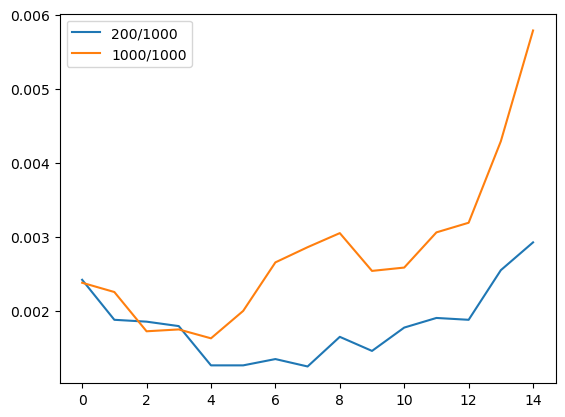

In [97]:
plt.plot(np.array(avg_rewards).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_1000).reshape((-1, N)).mean(axis=-1))
plt.legend(["200/1000", "1000/1000"])
plt.show()

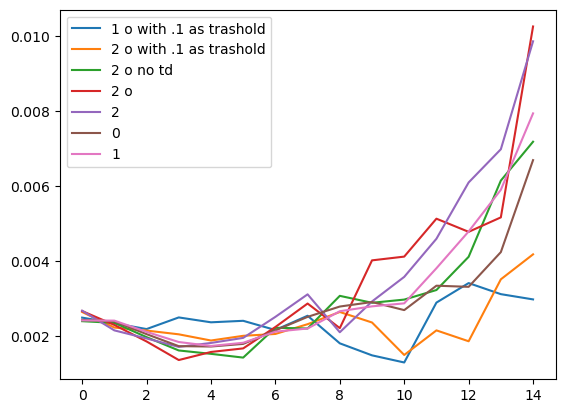

In [194]:
%matplotlib inline
plt.plot(np.array(avg_rewards_0_1_original_with_0_1_prob).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_0_2_original_with_0_1_prob).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_0_2_original_without_td).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_0_2_original).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_0_2).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_0_0).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_0_1).reshape((-1, N)).mean(axis=-1))
plt.legend(["1 o with .1 as trashold", "2 o with .1 as trashold", "2 o no td", "2 o", "2", "0", "1"])
plt.show()

 ### Random policy reward

In [120]:
random_env = get_env(1000)
random_rewards = []

for _ in trange(1000):
    original_probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    mask = get_probabilities_mask(random_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards == env_.FRUIT_REWARD))

100%|██████████| 1000/1000 [00:19<00:00, 50.05it/s]


## Training evaluation

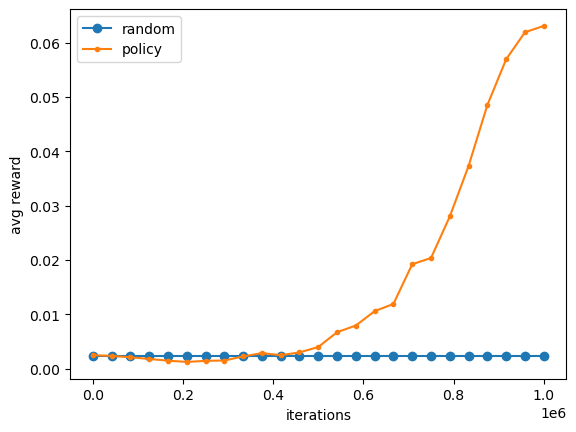

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
CHUNK_SIZE = 200
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards[700:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

 ## Test (graphical simulation)

In [158]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [159]:
test_env = get_env(3)

In [160]:
def animate(_):
    original_probs = tf.concat((agent(
        test_env.to_state()
    )[:-1]+ EPSILON, [[.25]*4]), axis=0)

    mask = get_probabilities_mask(test_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]

    actions = tf.random.categorical(tf.math.log(probs),1)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [161]:
# first three are policy guided, the fourth is random, to give a comparison
fig, axs = plt.subplots(1,3, figsize=(12,5))
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>

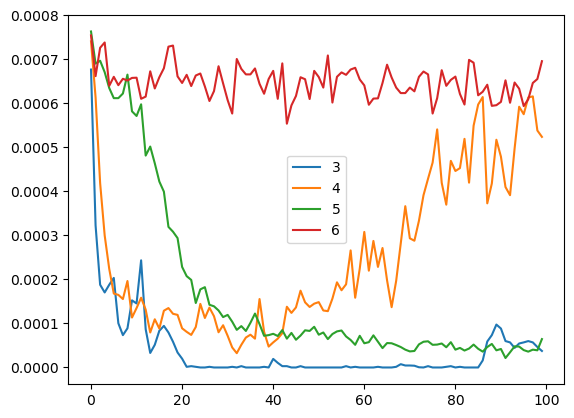

In [55]:
plt.plot(np.array(avg_rewards_3).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_4).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_5).reshape((-1, N)).mean(axis=-1))
plt.plot(np.array(avg_rewards_6).reshape((-1, N)).mean(axis=-1))
plt.legend("3456")

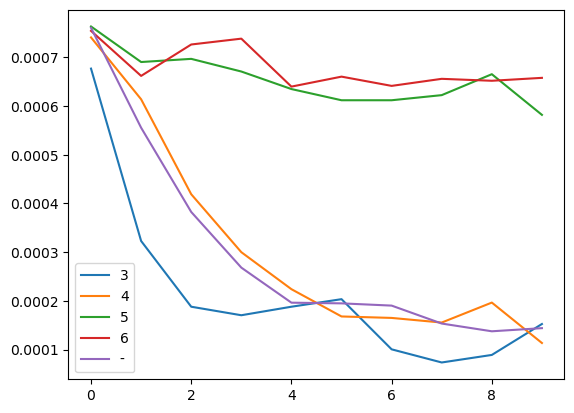

In [60]:
plt.plot(np.array(avg_rewards_3).reshape((-1, N)).mean(axis=-1)[:10])
plt.plot(np.array(avg_rewards_4).reshape((-1, N)).mean(axis=-1)[:10])
plt.plot(np.array(avg_rewards_5).reshape((-1, N)).mean(axis=-1)[:10])
plt.plot(np.array(avg_rewards_6).reshape((-1, N)).mean(axis=-1)[:10])
plt.plot(np.array(avg_rewards_10000).reshape((-1, N)).mean(axis=-1)) # come 4
plt.legend("3456-")

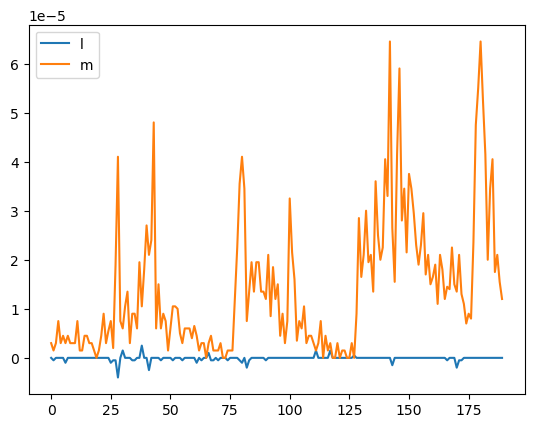

In [72]:
plt.plot(np.array(avg_rewards_25_learned).reshape((-1, N)).mean(axis=-1)[300:])
plt.plot(np.array(avg_rewards_25_masked).reshape((-1, N)).mean(axis=-1)[300:])
plt.legend("lm")

In [39]:
LOAD_FROM_MEMORY = True
MODELS_PREFIX = f"with_plus/py/models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)
agent_plus, value_plus, avg_rewards_plus = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

loaded
loaded


In [41]:
LOAD_FROM_MEMORY = True
MODELS_PREFIX = f"without/py/models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)
agent_without, value_without, avg_rewards_without = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

loaded
loaded


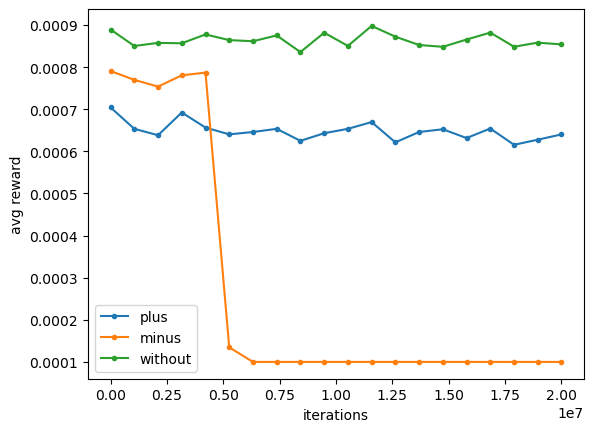

In [44]:
%matplotlib inline

CHUNK_SIZE = 1000
N = min(len(avg_rewards_plus), len(avg_rewards_minus), len(avg_rewards_without))//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
#plt.plot(x, np.array(random_rewards[700:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards_plus)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
points = np.array(avg_rewards_minus)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)+1e-4
plt.plot(x, points, marker=".")
points = np.array(avg_rewards_without)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)+2e-4
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["plus", "minus", "without"])

In [24]:
state = env_.to_state()
agent(state).numpy().round(3)

array([[0.564, 0.017, 0.396, 0.023],
       [0.587, 0.016, 0.383, 0.015],
       [0.767, 0.023, 0.165, 0.045],
       ...,
       [0.554, 0.018, 0.402, 0.027],
       [0.537, 0.015, 0.428, 0.02 ],
       [0.552, 0.014, 0.418, 0.015]], dtype=float32)

In [25]:
get_probabilities_mask(env_.boards, (1000,4))

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])